# WizardOfWikipedia: Knowledge-powered Conversational Agents
## Authors: 
 - Jacopo Di Ventura - jacopo.di.ventura@usi.ch
 - Jury Andrea D'Onofrio - jury.donofrio@usi.ch
 - Matteo Martinoli - matteo.martinoli@usi.ch
 - Roberto Neglia - roberto.neglia@usi.ch
 
#### Installation and upgrade of libraries

In [ ]:
%%time
!pip uninstall -y transformers -q
!pip install transformers==4.22.2 -q
!pip install --upgrade accelerate -q
!pip install -U sentence-transformers -q
!pip install datasets -q
!pip install hnswlib -q

#### Python library imports

In [2]:
import json
import numpy as np
import re
import torch
import pickle
import os
import hnswlib
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer, CrossEncoder
from datasets import Dataset, DatasetDict
from IPython.display import Audio
from IPython.utils import io

## Dataset: 
#### Load dataset

In [3]:
!wget https://parl.ai/downloads/wizard_of_wikipedia/wizard_of_wikipedia.tgz
!tar -xzvf 'wizard_of_wikipedia.tgz'

with open("data.json") as f:
    raw_data = json.load(f)

--2024-01-14 21:09:14--  https://parl.ai/downloads/wizard_of_wikipedia/wizard_of_wikipedia.tgz
Resolving parl.ai (parl.ai)... 18.160.143.55, 18.160.143.25, 18.160.143.56, ...
Connecting to parl.ai (parl.ai)|18.160.143.55|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://dl.fbaipublicfiles.com/parlai/wizard_of_wikipedia/wizard_of_wikipedia.tgz [following]
--2024-01-14 21:09:14--  https://dl.fbaipublicfiles.com/parlai/wizard_of_wikipedia/wizard_of_wikipedia.tgz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.243.25, 65.8.243.97, 65.8.243.119, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.243.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 971505856 (926M) [application/x-tar]
Saving to: 'wizard_of_wikipedia.tgz'

wizard_of_wikipedia 100%[===================>] 926.50M   175MB/s    in 5.8s    

2024-01-14 21:09:20 (161 MB/s) - 'wizard_of_wikipedia.tgz' saved [971505856/97

In [4]:
# Device definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Original Dataset
Composed of chats beween two participants, with one of the participants selecting a beginning topic. During the conversation the topic is allowed to naturally change. The two participants, however, are not symmetric: one will play the role of a knowledgeable expert (which we refer to as the Wizard) while the other is a curious learner (the Apprentice).

Each entry is composed by the following items:

<code>

chosen_topic: string

persona: string

wizard_eval: integer

dialog: list[dict]

chosen_topic_passage: list[string]

</code>

In [5]:
def pretty_print_passage(passage):
    a = f"Speaker: {passage['speaker']} | Text: {passage['text'][:passage_cutoff]} {'...' if len(passage['text']) > passage_cutoff else ''} | "
    b = f"Retrieved Passages: {[list(p.keys())[0] for p in passage['retrieved_passages']][:2]}"
    return a + b

newline = '\n'
passage_cutoff = 50

def pretty_print_raw(raw_el):
    print(f"Starting sentence: {raw_el['persona']} | Initial topic: {raw_el['chosen_topic']}")
    print(f"Dialog: \n{newline.join([pretty_print_passage(passage) for passage in raw_el['dialog'][:2]])}")

#### Example:

Notice that the conversation can be started by both apprentice and wizard

In [6]:
for el in raw_data[:2]:
    pretty_print_raw(el)
    print('\n')

Starting sentence: i enjoy movies about aliens invading the earth. | Initial topic: Science fiction
Dialog: 
Speaker: 0_Wizard | Text: I think science fiction is an amazing genre for an ... | Retrieved Passages: ['Hyperspace (science fiction)', 'Science fiction']
Speaker: 1_Apprentice | Text: I'm a huge fan of science fiction myself!   | Retrieved Passages: ['Science fiction', 'History of science fiction']


Starting sentence: i have high speed internet. | Initial topic: Internet access
Dialog: 
Speaker: 0_Apprentice | Text: Can you imagine the world without internet access? ... | Retrieved Passages: ['Right to Internet access', 'Internet censorship and surveillance by country']
Speaker: 1_Wizard | Text: No I could not! I couldn't imagine living when int ... | Retrieved Passages: ['Internet access', 'Internet censorship and surveillance by country']




In [7]:
# Length of original dataset
len(raw_data)

22311

In [8]:
# Average dialog length:
dlens = np.array([len(el['dialog']) for el in raw_data])
dlens.mean()

9.053785128411993

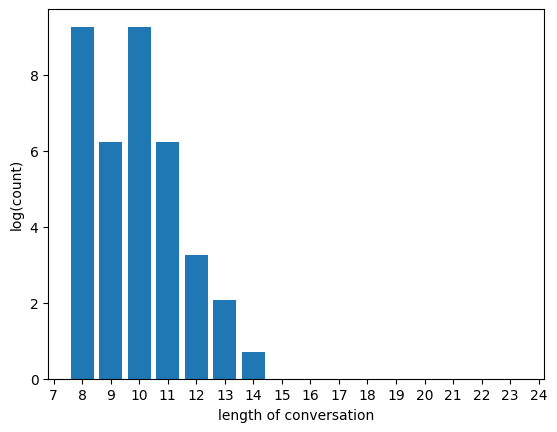

In [9]:
plt.ylabel('log(count)')
plt.xlabel('length of conversation')
plt.xticks(np.arange(7,25))
unique, count = np.unique(dlens, return_counts=True)
plt.bar(unique, np.log(count))
assert count.sum() == len(raw_data)

### Our (parsed) Dataset
Composed of statements or questions and answers beween two participants. The question is asked by the apprentice (the user), while the answer is given by the bot. Its answer is based on some context given as input together with the question.

Each entry is composed by the following items:

<code>

input: string

target: string

context: string

</code>



Where:

- <b>input</b> is the question of the apprentice

- <b>target</b> is the desired response given by the bot

- <b>context</b> is where the response (target) to the question (input) should be taken from



Therefore from each conversation (single element in the original dataset) we extract roughly <code>len(conversation) // 2</code> elements for our new dataset.

In the original dataset either the wizard or the apprentice can begin the conversation, since we are only interested in answers given by the wizard (knowledge based) we only keep apprentice --> wizard interactions not the other way around. Therefore depending on who begins the conversation the extraction of the data varies slightly

#### `extract_apprentice_start` Function

- The `extract_apprentice_start` function is designed to extract all the dialogs started by the apprentice.

- Args:
  - `data` (dict): A sample from the raw dataset. 
  
- Returns:
  - `ds` (list): A list of dialogs, which are dictionaries with fields 'context', 'input', and 'target'.
  
  
#### `extract_wizard_start` Function

- The `extract_wizard_start` function is designed to extract all the dialogs started by the wizard.

- Args:
  - `data` (dict): A sample from the raw dataset. 
  
- Returns:
  - `ds` (list): A list of dialogs, which are dictionaries with fields 'context', 'input', and 'target'.

In [10]:
def extract_wizard_start(data):
    assert data['dialog'][0]['speaker'] == '0_Apprentice'

    # Extract apprentice, wizard, and passages from the dialog data
    apprentice = [el['text'] for el in data['dialog'] if el['speaker'] == '0_Apprentice']
    wizard = [el['text'] for el in data['dialog'] if el['speaker'] == '1_Wizard']
    passages = [list(el['checked_sentence'].values())[0] if len(el['checked_sentence'].values()) > 0 else 'no_passages_used' for el in data['dialog'] if el['speaker'] == '1_Wizard']

    # Trim the lists to the length of the shorter one between apprentice and wizard
    trim = min(len(apprentice), len(wizard))
    
    # Create a list of dictionaries representing dialog samples with input, target, and context
    ds = []
    for a, w, p in zip(apprentice[:trim], wizard[:trim], passages[:trim]):
        if p == 'no_passages_used':
            continue
        dialog = {}
        dialog['input'] = a
        dialog['target'] = w
        dialog['context'] = p
        ds.append(dialog)

    return ds


def extract_apprentice_start(data):
    assert data['dialog'][0]['speaker'] == '0_Wizard'

    # Extract apprentice, wizard, and passages from the dialog data
    apprentice = [data['persona']]
    apprentice.extend([el['text'] for el in data['dialog'] if el['speaker'] == '1_Apprentice'])
    wizard = [el['text'] for el in data['dialog'] if el['speaker'] == '0_Wizard']
    passages = [list(el['checked_sentence'].values())[0] if len(el['checked_sentence'].values()) > 0 else 'no_passages_used' for el in data['dialog'] if el['speaker'] == '0_Wizard']

    # Trim the lists to the length of the shorter one between apprentice and wizard
    trim = min(len(wizard), len(apprentice))

    # Create a list of dictionaries representing dialog samples with input, target, and context
    ds = []
    for a, w, p in zip(apprentice[:trim], wizard[:trim], passages[:trim]):
        if p == 'no_passages_used':
            continue
        dialog = {}
        dialog['input'] = a
        dialog['target'] = w
        dialog['context'] = p
        ds.append(dialog)

    return ds

#### Example:

Notice that from a single element of raw_data we extract multiple elements

In [11]:
extracted = extract_apprentice_start(raw_data[0])

print('Elements: ',len(extracted))
extracted[:2]

Elements:  4


[{'input': 'i enjoy movies about aliens invading the earth.',
  'target': "I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.",
  'context': 'Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.'},
 {'input': "I'm a huge fan of science fiction myself! ",
  'target': 'Awesome! I really love how sci-fi storytellers focus on political/social/philosophical issues that would still be around even in the future. Makes them relatable.',
  'context': 'Science fiction films have often been used to focus on political or social issues, and to explore philosophical issues like the human condition.'}]

In [12]:
extracted = extract_wizard_start(raw_data[1])

print('Elements: ',len(extracted))
extracted[:2]

Elements:  4


[{'input': 'Can you imagine the world without internet access? ',
  'target': "No I could not! I couldn't imagine living when internet access was rare and very few people had it!",
  'context': 'Internet access was once rare, but has grown rapidly.'},
 {'input': 'Oh me either! It seems like such a long time ago. I wonder when Internet was first created?',
  'target': 'It used to be restricted, but around 1995, the restricted were lifted and commercial use of it began',
  'context': 'Use by a wider audience only came in 1995 when restrictions on the use of the Internet to carry commercial traffic were lifted.'}]

#### Build the list of all dialogs

In [13]:
all_dialogs = []
for sample in raw_data:
    if sample["dialog"][0]["speaker"] == "0_Wizard":
        all_dialogs.extend(extract_apprentice_start(sample))
    else:
        all_dialogs.extend(extract_wizard_start(sample))

In [14]:
# Length of processed dataset
print(len(all_dialogs))

94029


## Fine-tuning gpt2 model:
### Define tokenizer and gpt2 model

In [15]:
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

#### `sample_to_string` Function

- The `sample_to_string` function is designed to format the sample information into a string. It includes the context, input text, and the reply using information in the context.

- Args:
  - `sample` (dict): A dictionary with fields 'context', 'input', and 'target'.
  - `eos_token` (str): An end-of-sequence token used for separating different parts of the formatted string.

- Returns:
  - `str`: A formatted string that combines the context, input text, and reply.


In [16]:
def sample_to_string(sample, eos_token):
    return f"context: {sample['context']} {eos_token} input text: {sample['input']} {eos_token} reply using information in the context: {sample['target']} {eos_token}"

In [17]:
# Example of input string
sample_to_string(all_dialogs[0], tokenizer.eos_token)

"context: Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life. <|endoftext|> input text: i enjoy movies about aliens invading the earth. <|endoftext|> reply using information in the context: I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts. <|endoftext|>"

In [18]:
# Convert all dialogs into strings
formatted_data = [sample_to_string(sample, tokenizer.eos_token) for sample in all_dialogs]

In [31]:
# Split the data in training and validation sets
np.random.shuffle(formatted_data)
used_data = formatted_data[: len(formatted_data) // 2]
training_data = used_data[: int(len(used_data) * 0.99)]
validation_data = used_data[int(len(used_data) * 0.99) :]

print(len(training_data), len(validation_data))

train_data = Dataset.from_dict({"text": training_data})
valid_data = Dataset.from_dict({"text": validation_data})

data = DatasetDict()
data["train"] = train_data
data["validation"] = valid_data

46543 471


#### Tokenize data

In [20]:
def tokenize_function(examples):
    input_encodings = tokenizer(examples["text"], padding=True, truncation=True)
    sample = {"input_ids": input_encodings.input_ids}
    return sample

In [21]:
tokenized_data = data.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [23]:
# Set the hyperparameters
training_args = TrainingArguments(
    output_dir="CustomTrainerName",
    evaluation_strategy="steps",
    eval_steps=20,
    gradient_accumulation_steps=16,
    learning_rate=4e-5, 
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    data_collator=data_collator,
) 

In [ ]:
trainer.train()

#### Save fine-tuned model

In [25]:
checkpoint_path = (f"trained_model")
tokenizer.save_pretrained(checkpoint_path)
model.save_pretrained(checkpoint_path)
print(f"Checkpoint saved at: '{checkpoint_path}'")

tokenizer config file saved in trained_model/tokenizer_config.json
Special tokens file saved in trained_model/special_tokens_map.json
Configuration saved in trained_model/config.json
Model weights saved in trained_model/pytorch_model.bin


Checkpoint saved at: 'trained_model'


In [26]:
# Compress the folder containing the model
!zip -r file.zip trained_model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: trained_model/ (stored 0%)
  adding: trained_model/special_tokens_map.json (deflated 60%)
  adding: trained_model/pytorch_model.bin (deflated 9%)
  adding: trained_model/tokenizer_config.json (deflated 41%)
  adding: trained_model/merges.txt (deflated 53%)
  adding: trained_model/config.json (deflated 52%)
  adding: trained_model/vocab.json (deflated 59%)
  adding: trained_model/tokenizer.json (deflated 72%)


## Retrieve passages:
#### Load SentenceTransformer and CrossEncoder models
In this code block, two pretrained models are loaded for different natural language processing (NLP) tasks:

1. **Sentence Transformer Model**
   - `semb_model` is initialized using the 'multi-qa-MiniLM-L6-cos-v1' model. This model is designed for generating embeddings for sentences, which can be useful for various NLP tasks such as similarity analysis and clustering.

2. **Cross-Encoder Model**
   - `xenc_model` is initialized using the 'cross-encoder/ms-marco-MiniLM-L-6-v2' model. This model is intended for cross-encoder tasks and can be used for tasks that involve ranking or comparing pairs of text.

These pretrained models provide powerful tools for various NLP applications and tasks.


In [ ]:
print('Loading SentenceTransformer...', end="\r")
with io.capture_output() as captured:
    semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
print('Loading SentenceTransformer. Done')
    
print('Loading CrossEncoder...', end="\r")
with io.capture_output() as captured:    
    xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
print('Loading CrossEncoder. Done')

#### Extract list of passages from raw data

In [28]:
wikipedia_passages = {}
i = 0
for conv in raw_data:
    i += 1
    topic = conv["chosen_topic"]
    chosen_topic_passage = conv["chosen_topic_passage"]
    if topic not in wikipedia_passages:
        wikipedia_passages[topic] = set()
    wikipedia_passages[topic].update(chosen_topic_passage)

    for turn in conv["dialog"]: 
        retrieved_topics = turn["retrieved_topics"] 
        retrieved_passages = turn["retrieved_passages"]
        for topic, passage in zip(retrieved_topics, retrieved_passages):
            try:
                tmp = passage[topic]
            except:
                tmp = passage[list(passage.keys())[0]]
            if topic not in wikipedia_passages:
                wikipedia_passages[topic] = set()
            wikipedia_passages[topic].update(tmp)
            
passages = []
for passage in wikipedia_passages.values():
    if len(passage) < 7:
        passages.extend(list(passage))
        
with open('passages_list.json', 'w') as f:
    json.dump(passages, f)

#### Compute and save embeddings

In [29]:
cache_path = "embeddings_cache.pickle"

passage_embeddings = semb_model.encode(passages, convert_to_tensor=True, show_progress_bar=True, device=device)
with open(cache_path, "wb") as f:
    pickle.dump(passage_embeddings, f)

Batches:   0%|          | 0/23644 [00:00<?, ?it/s]

Computing embeddings. Done


#### Create and save HSWN index

In [ ]:
# Initialize an HNSW index for efficient similarity search using cosine distance.
print('Creating HNSW index...', end="\r")
index = hnswlib.Index(space='cosine', dim=passage_embeddings.size(1))
index_path = './embeddings_index_100.index' 

index.init_index(max_elements=passage_embeddings.size(0), ef_construction=100, M=64) # see https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md for parameter description
# Compute the HNSWLIB index
index.add_items(passage_embeddings.cpu(), list(range(len(passage_embeddings))))
# Save the index to a file for future loading
index.save_index(index_path) 
print('Creating HNSW index. Done')